In [1]:
import os
from utils import load_mvtec_dataset
from keras.preprocessing.image import image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
MVTEC_CATEGORIES = [
    "bottle",
    "cable",
    "capsule",
    "carpet",
    "grid",
    "hazelnut",
    "leather",
    "metal_nut",
    "pill",
    "screw",
    "tile",
    "toothbrush",
    "transistor",
    "wood",
    "zipper",
]

category = MVTEC_CATEGORIES[13]
print(category)

capsule


In [3]:
batch_size = 32
img_height = 224
img_width = 224

''' Image paths '''
train_path=f"mvtec_data_clf_rot/{category}/train"
test_path=f"mvtec_data_clf_rot/{category}/test"
val_path=f"mvtec_data_clf_rot/{category}/val"

In [4]:
x_train=[]
for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(img_height,img_width))
        x_train.append(img_arr)
x_test=[]
for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(img_height,img_width))
        x_test.append(img_arr)
x_val=[]
for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(img_height,img_width))
        x_val.append(img_arr)

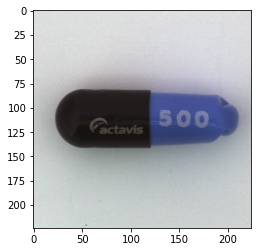

In [5]:
plt.imshow(x_test[0])

In [6]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [7]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

In [8]:
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (img_height,img_width),
                                                 batch_size = batch_size,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (img_height, img_width),
                                            batch_size = batch_size,
                                            class_mode = 'sparse')


train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes
training_set.class_indices

Found 1048 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


{'bad': 0, 'good': 1}

In [9]:
from keras import layers
from keras.models import Model, Sequential
from keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [10]:
resnet50 = ResNet50V2(input_shape = (224, 224, 3), weights='imagenet', include_top=False)
# don't train existing weights
for layer in resnet50.layers:
    layer.trainable = False
x = Flatten()(resnet50.output)

prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=resnet50.input, outputs=prediction)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [12]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor='val_loss', patience = 1)

In [13]:
# Model
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

history = model.fit(
  train_x, 
  train_y,
  validation_data=(val_x, val_y),
  epochs=10,
  batch_size=32,shuffle=True,
  callbacks=cb_early_stopper)

Epoch 1/4
33/33 [==============================] - 98s 3s/step - loss: 7.0904 - accuracy: 0.6317 - val_loss: 1.1359 - val_accuracy: 0.7889
Epoch 2/4
33/33 [==============================] - 101s 3s/step - loss: 1.0343 - accuracy: 0.8206 - val_loss: 0.5684 - val_accuracy: 0.8278
Epoch 3/4
33/33 [==============================] - 104s 3s/step - loss: 0.6418 - accuracy: 0.8683 - val_loss: 0.9600 - val_accuracy: 0.7889
Epoch 4/4
33/33 [==============================] - 102s 3s/step - loss: 0.3308 - accuracy: 0.9265 - val_loss: 0.3477 - val_accuracy: 0.8889


INFO:tensorflow:Assets written to: Model/capsule\assets


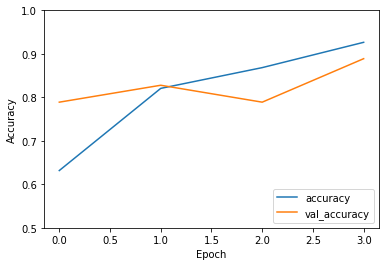

In [14]:
model.save(f"Model/{category}")
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

2/2 - 5s - loss: 0.6301 - accuracy: 0.7727 - 5s/epoch - 3s/step


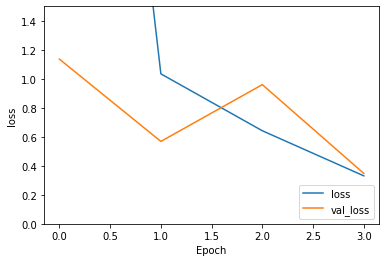

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0.0, 1.5])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_x,  test_y, verbose=2)

In [16]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

pred = model.predict_generator(test_x, steps = len(test_x), verbose = 1)
predicted_class_indices = np.argmax(pred, axis = 1)
print("True: ", test_y)
print("Pred: ", predicted_class_indices)


C:\Users\tobia\AppData\Local\Temp\ipykernel_17492\1511004400.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_x, steps = len(test_x), verbose = 1)


44/44 [==============================] - 10s 162ms/step
True:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Pred:  [0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1]


              precision    recall  f1-score   support

           0       0.62      0.71      0.67        14
           1       0.86      0.80      0.83        30

    accuracy                           0.77        44
   macro avg       0.74      0.76      0.75        44
weighted avg       0.78      0.77      0.78        44



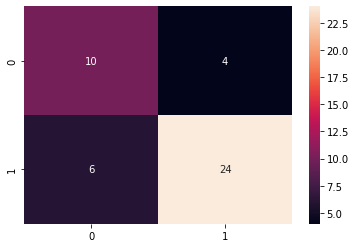

In [17]:
import seaborn as sns
cm = confusion_matrix(test_y, predicted_class_indices)

sns.heatmap(cm,annot=True)
print(classification_report(test_y, predicted_class_indices))

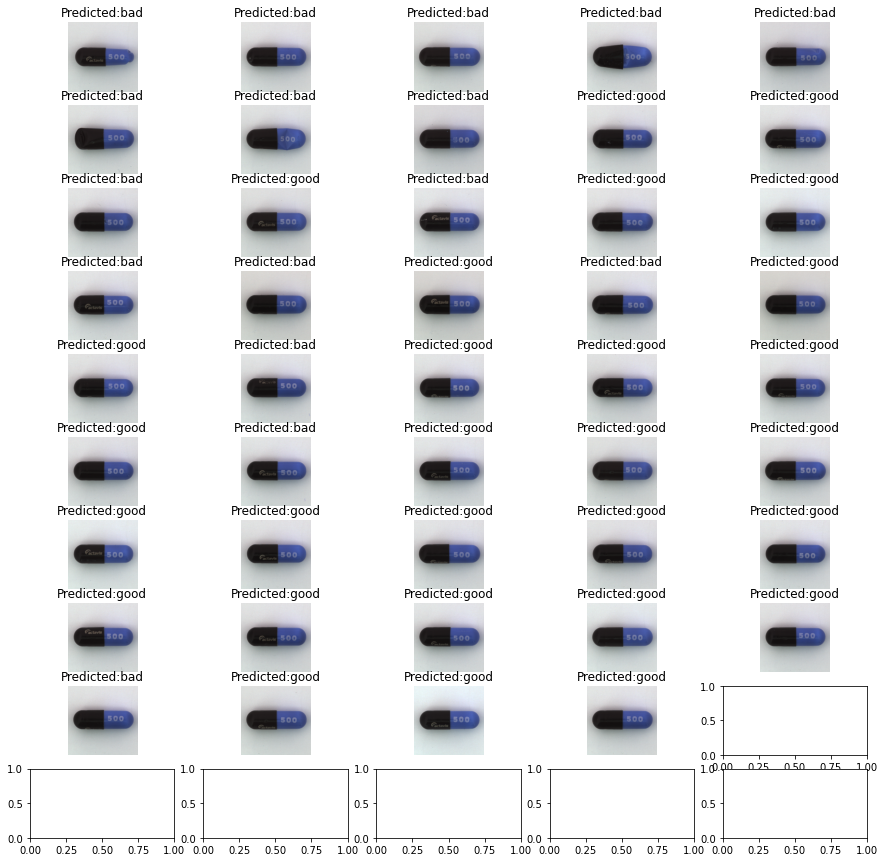

In [18]:
import cv2
f, ax = plt.subplots(10, 5, figsize = (15, 15))

for i in range(len(test_x)):
    img = test_x[i]
    predicted_class = "good" if predicted_class_indices[i] else "bad"

    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_title("Predicted:{}".format(predicted_class))  